# Определение стоимости автомобилей

<img src="https://s3.amazonaws.com/thumbnails.illustrationsource.com/huge.14.74944.JPG" width="170" align="left"/>Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. <br>
<b>Заказчику важны:</b><br>
◦ качество предсказания;<br>
◦ скорость предсказания;<br>
◦ время обучения.<br>

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

## Настройка проекта.

### Импорт необходимых для исследования библиотек, модулей, классов и функций.

In [1]:
import optuna
import phik
import random
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import dump, load
from lightgbm import LGBMRegressor
from os.path import exists

from phik import report
from phik.report import plot_correlation_matrix

from scipy.stats import randint, uniform

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    RandomizedSearchCV,
    ShuffleSplit,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

### Настройка окружения.

In [2]:
start_time = time.time()

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

### Используемые пользовательские функции, классы и глобальные переменные.

#### Глобальные переменные.

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#### Пользовательские функции.

In [4]:
def my_z_remove_outliers(X, columns, z_threshold=3):
    for column in columns:
        z_scores = np.abs((X[column] - X[column].mean()) / X[column].std())
        X[column] = X[column][z_scores < z_threshold]
    return X

def my_fillna_with_no_data(X):
    for column in X.columns:
        X[column].fillna(column + '_no_data', inplace=True)
    return X

def my_extract_month_from_dates(X, columns):
    for column in columns:
        X[column] = pd.DatetimeIndex(X[column]).month
    return X

def my_drop_columns(X, columns_to_drop):
    X.drop(columns_to_drop, axis=1, inplace=True)
    return X

def my_objective(trial):
    alpha = trial.suggest_uniform('alpha', 0, 0.21)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    
    pipeline_ridge_optuna = Pipeline([
        ('preprocessing', trans_pipeline),
        ('ridge', Ridge(alpha=alpha, fit_intercept=fit_intercept, random_state=RANDOM_STATE))
    ])
    
    pipeline_ridge.fit(X_train, y_train)
    y_pred = pipeline_ridge.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

def my_processing_outliers(X, columns, ranges):
    for column in columns:
        min_val, max_val = ranges[column]
        X[column] = np.where((X[column] < min_val) | (X[column] > max_val), np.nan, X[column])
    return X

def my_WITTY(df, weights):
    scaler = MinMaxScaler()
    time_columns = ['Время обучения', 'Время предсказания']
    df_scaled = pd.DataFrame(scaler.fit_transform(df[time_columns]), columns=time_columns)
    df_scaled['RMSE модели'] = np.log(df['RMSE модели'])
    df['WITTY index'] = (
        weights['Время обучения'] * df_scaled['Время обучения'] +
        weights['Время предсказания'] * df_scaled['Время предсказания'] +
        weights['RMSE модели'] * df_scaled['RMSE модели']
    )
    return df.sort_values(by='WITTY index', ascending=True)

## Подготовка данных.

### Предподготовка.

#### Загрузка данных.

In [5]:
try:
    autos = pd.read_csv(
        'autos.csv',
        engine='python',
        sep=None,
        parse_dates=['DateCrawled', 'DateCreated', 'LastSeen']
    )
except:
    autos = pd.read_csv(
        '/datasets/autos.csv',
        engine='python',
        sep=None,
        parse_dates=['DateCrawled', 'DateCreated', 'LastSeen']
    )

#### Разделение данных на обучающую и тестовую выборки.

In [6]:
shuffle_split = ShuffleSplit(n_splits=1, test_size=0.25, random_state=RANDOM_STATE)

for train_index, test_index in shuffle_split.split(autos):
    autos_train_set = autos.loc[train_index].copy()
    autos_test_set = autos.loc[test_index].copy()
    
autos_train_set.reset_index(inplace=True, drop=True)
autos_test_set.reset_index(inplace=True, drop=True)

In [7]:
print(f'Доля тренировочной выборки: {autos_train_set.shape[0] / autos.shape[0]:.2f}')
print(f'Доля тестовой выборки: {autos_test_set.shape[0] / autos.shape[0]:.2f}')

Доля тренировочной выборки: 0.75
Доля тестовой выборки: 0.25


In [8]:
autos_train_set.reset_index(inplace=True, drop=True)
autos_test_set.reset_index(inplace=True, drop=True)

#### Обзор данных.

In [9]:
autos_train_set.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
263837,2016-03-07 13:52:34,8999,NaN,2017,manual,60,polo,50000,12,petrol,volkswagen,no,2016-03-07,0,50935,2016-04-04 11:45:04
206882,2016-03-31 14:51:56,5500,bus,2011,auto,109,b_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-31,0,21033,2016-04-06 07:45:19
64907,2016-03-07 18:44:44,4500,small,1998,manual,125,polo,80000,7,petrol,volkswagen,no,2016-03-07,0,58710,2016-04-07 02:44:21
123096,2016-04-04 23:50:21,380,small,2000,manual,75,twingo,150000,11,petrol,renault,yes,2016-04-04,0,72622,2016-04-07 06:16:08
222135,2016-04-04 12:49:00,16700,sedan,2012,manual,140,passat,60000,3,gasoline,volkswagen,no,2016-04-04,0,38228,2016-04-06 14:16:04


In [10]:
print(autos_train_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265776 entries, 0 to 265775
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        265776 non-null  datetime64[ns]
 1   Price              265776 non-null  int64         
 2   VehicleType        237668 non-null  object        
 3   RegistrationYear   265776 non-null  int64         
 4   Gearbox            250825 non-null  object        
 5   Power              265776 non-null  int64         
 6   Model              250970 non-null  object        
 7   Kilometer          265776 non-null  int64         
 8   RegistrationMonth  265776 non-null  int64         
 9   FuelType           240988 non-null  object        
 10  Brand              265776 non-null  object        
 11  Repaired           212327 non-null  object        
 12  DateCreated        265776 non-null  datetime64[ns]
 13  NumberOfPictures   265776 non-null  int64   

In [11]:
autos_train_set.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,265776,"265,776.000",237668,"265,776.000",250825,"265,776.000",250970,"265,776.000","265,776.000",240988,265776,212327,265776,"265,776.000","265,776.000",265776
unique,218153,NaN,8,NaN,2,NaN,249,NaN,NaN,7,40,2,102,NaN,NaN,145279
top,2016-03-19 21:49:56,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-07 09:44:27
freq,6,NaN,68668,NaN,201243,NaN,21899,NaN,NaN,162208,57776,185416,10334,NaN,NaN,15
first,2016-03-05 14:06:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-10 00:00:00,NaN,NaN,2016-03-05 14:15:08
last,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00,NaN,NaN,2016-04-07 14:58:51
mean,NaN,"4,408.063",NaN,"2,004.295",NaN,109.582,NaN,"128,225.686",5.711,NaN,NaN,NaN,NaN,0.000,"50,506.427",NaN
std,NaN,"4,505.713",NaN,92.255,NaN,174.759,NaN,"37,891.095",3.728,NaN,NaN,NaN,NaN,0.000,"25,794.679",NaN
min,NaN,0.000,NaN,"1,000.000",NaN,0.000,NaN,"5,000.000",0.000,NaN,NaN,NaN,NaN,0.000,"1,067.000",NaN
25%,NaN,"1,050.000",NaN,"1,999.000",NaN,68.000,NaN,"125,000.000",3.000,NaN,NaN,NaN,NaN,0.000,"30,163.000",NaN


In [12]:
print('Количество полных дубликатов в данных:', autos_train_set.duplicated().sum())

Количество полных дубликатов в данных: 2


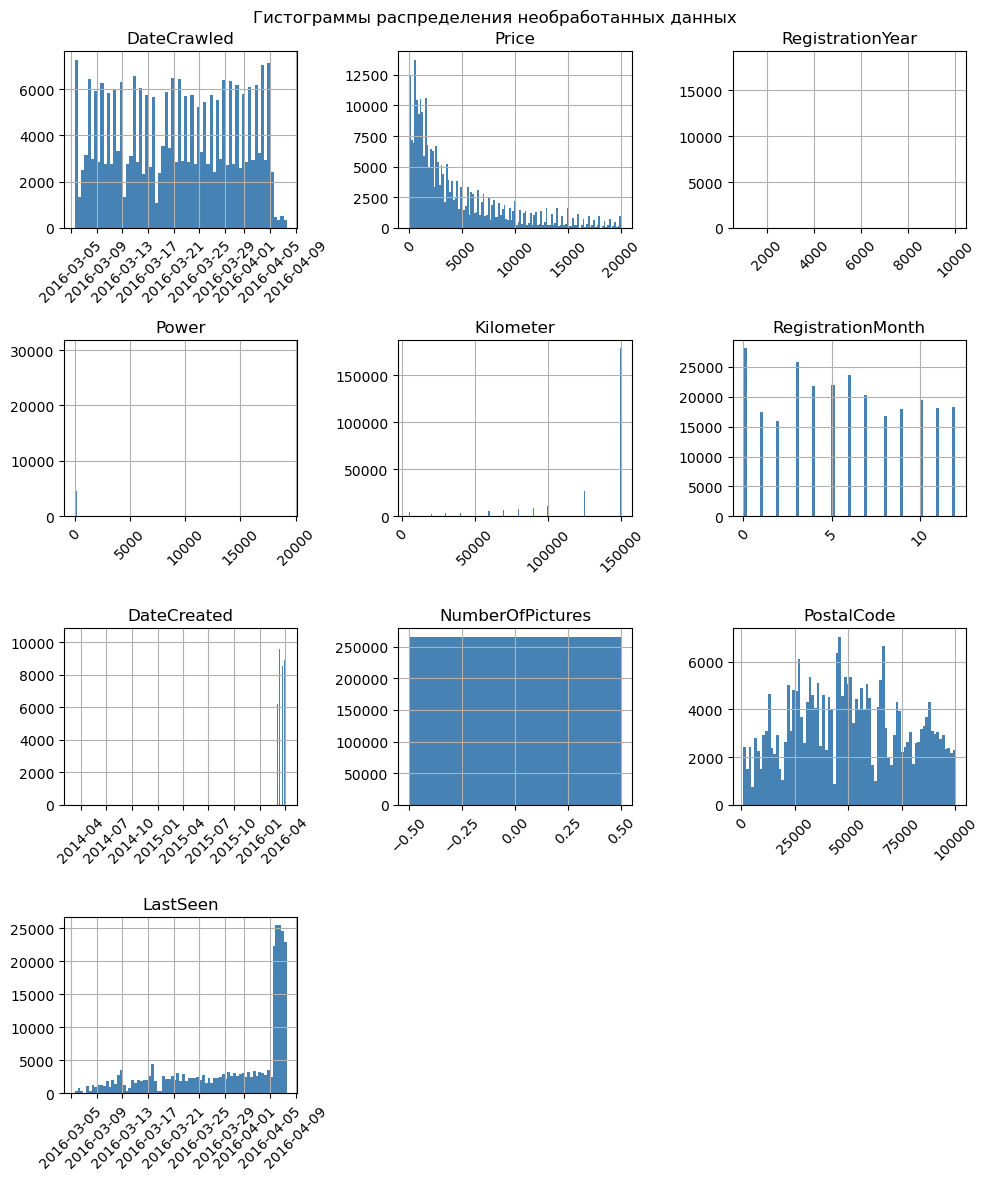

In [13]:
fig, axes = plt.subplots(figsize=(10, 12))
autos_train_set.hist(bins='auto', xrot=45, color='SteelBlue', ax=axes)
plt.suptitle('Гистограммы распределения необработанных данных')
plt.tight_layout()
plt.show()

### Обработка данных.

#### Обработка аномалий и выбросов.

In [14]:
autos_train_set.drop_duplicates(inplace=True)

OUTLIERS = ['Power', 'RegistrationYear', 'Price']
# null = my_z_remove_outliers(autos_train_set, OUTLIERS)

ranges = {
    'Power': (40, 600),
    'RegistrationYear': (1970, 2016),
    'Price': (300, 20000) # Price outliers now fixed for train
}
null = my_processing_outliers(autos_train_set, OUTLIERS, ranges)

autos_train_set.dropna(subset=OUTLIERS, inplace=True)

In [15]:
autos_test_set.drop_duplicates(inplace=True)

OUTLIERS = ['Power', 'RegistrationYear', 'Price']
# null = my_z_remove_outliers(autos_train_set, OUTLIERS)

ranges = {
    'Power': (40, 600),
    'RegistrationYear': (1970, 2016),
    'Price': (300, 20000) # Price outliers now fixed for test
}
null = my_processing_outliers(autos_test_set, OUTLIERS, ranges)

autos_test_set.dropna(subset=OUTLIERS, inplace=True)

In [16]:
print(autos_train_set.isna().sum())

DateCrawled              0
Price                    0
VehicleType           7215
RegistrationYear         0
Gearbox               3629
Power                    0
Model                 7576
Kilometer                0
RegistrationMonth        0
FuelType             10566
Brand                    0
Repaired             29815
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [17]:
autos_train_set.reset_index(inplace=True, drop=True)

#### Препроцессинг данных.

In [18]:
X_autos_train = autos_train_set.drop(['Price'], axis=1).reset_index(drop=True)
y_autos_train = autos_train_set['Price'].reset_index(drop=True)

In [19]:
null = my_fillna_with_no_data(autos_train_set)

#DATE_COLUMNS = ['DateCrawled', 'DateCreated', 'LastSeen']
#null = my_extract_month_from_dates(autos_train_set, DATE_COLUMNS)

#DROP_COLUMNS = ['NumberOfPictures']
DROP_COLUMNS = ['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen']
null = my_drop_columns(autos_train_set, DROP_COLUMNS)

#### Визуализация обработки.

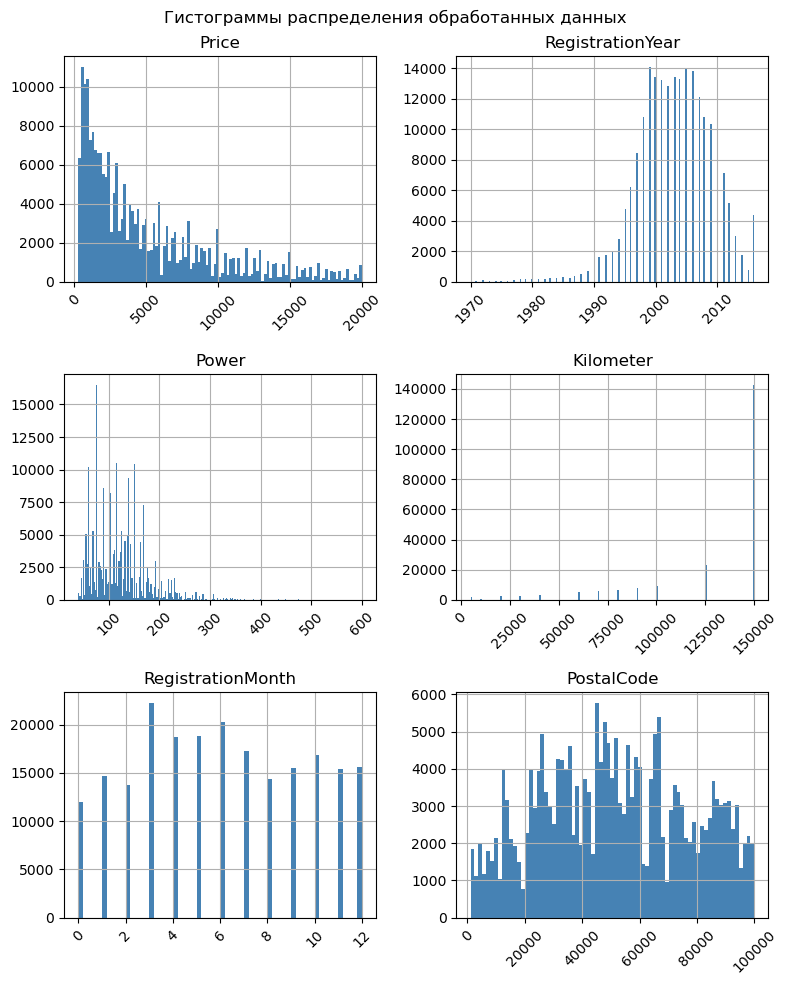

In [20]:
fig, axes = plt.subplots(figsize=(8, 10))
autos_train_set.hist(bins='auto', xrot=45, color='SteelBlue', ax=axes)
plt.suptitle('Гистограммы распределения обработанных данных')
plt.tight_layout()
plt.show()

### Краткий вывод.

Выводы по Подготовке данных:

1. В процессе подготовки данных была осуществлена автоматическая загрузка данных из двух источников - локального и сервера Практикума Яндекса.

2. Для последующего обучения модели данные были разделены на обучающую и тестовую выборки с использованием метода `ShuffleSplit` и проверку разбиения на соотношение $25/75$.

3. Предварительный обзор обучающих и тестовых данных с помощью случайного метода `sample()` позволил получить общее представление о распределении признаков и оценить их качество.

4. Анализ обучающих данных с использованием метода `info()` выявил наличие пропусков. Для их заполнения был применен подход, основанный на заполнении пропусков категориальными значениями, соответствующими признаку.

5. Метод `describe()` был использован для изучения обучающих данных. Он выявил наличие выбросов и аномалий, которые могут искажать результаты обучения модели. Для устранения этих проблем был применен метод нативной обработки данных.

6. В процессе анализа гистограмм распределения данных была выявлена необходимость дополнительной предобработки для удаления выбросов и аномалий.

7. Путем удаления полных дубликатов в обучающих данных мы исключили возможность искажения результатов и повысили качество выборки.

8. Неинформативные признаки были удалены, поскольку они не предоставляли полезной информации для обучения модели.

9. После проведения всех преобразований и предобработки данных было проанализировано распределение данных снова. Отмечено значительное улучшение качества данных.

## Обучение моделей

### Краткий PhiK анализ данных.

In [21]:
INTERVAL_COLUMNS_EXCL_PRC = [
    'DateCrawled', 'RegistrationYear', 'Power', 'Kilometer',
    'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'
]

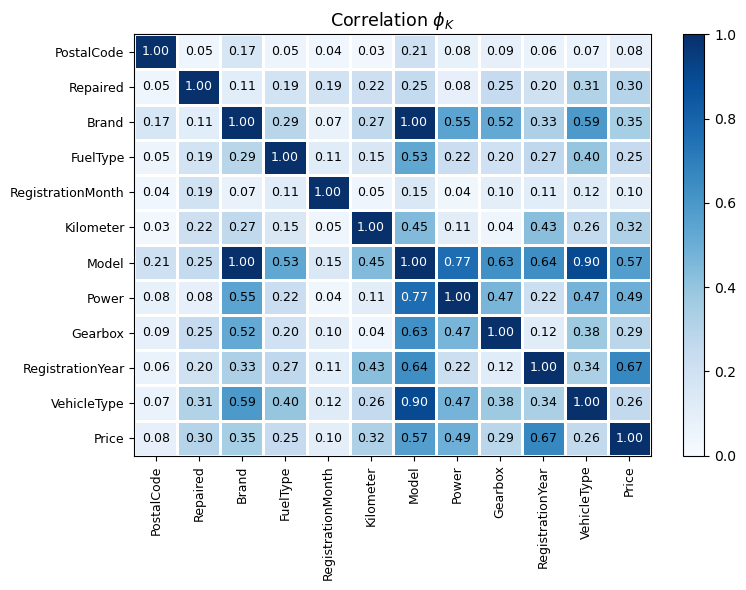

In [22]:
phik_overview = autos_train_set.phik_matrix(interval_cols = INTERVAL_COLUMNS_EXCL_PRC + ['Price'])
plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    vmin=0, vmax=1, color_map='Blues', 
    title=r'Correlation $\phi_K$', 
    fontsize_factor=0.9, 
    figsize=(8, 6)
)
plt.tight_layout()

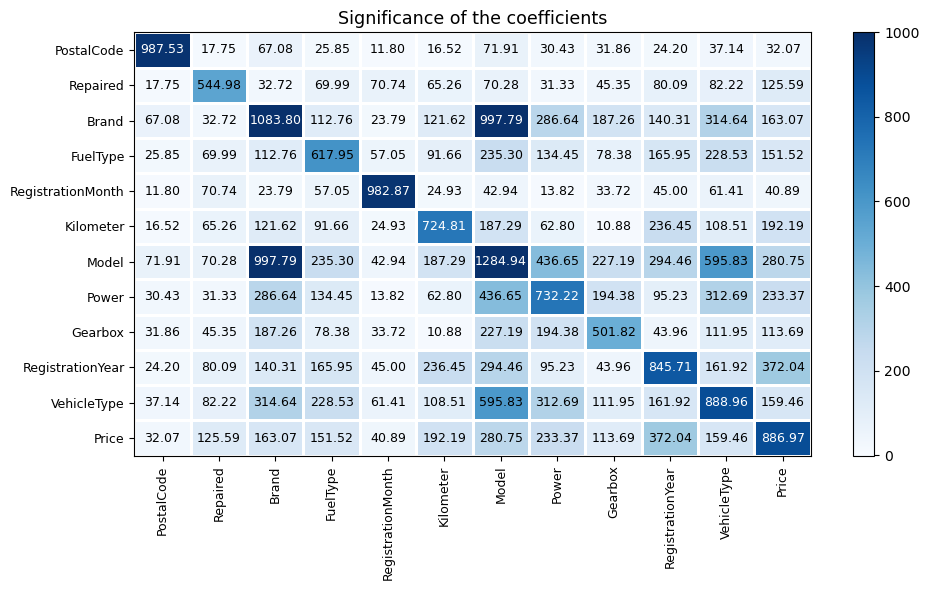

In [23]:
significance_overview = autos_train_set.significance_matrix(interval_cols = INTERVAL_COLUMNS_EXCL_PRC + ['Price'])
plot_correlation_matrix(
    significance_overview.fillna(0).values, 
    x_labels=significance_overview.columns, 
    y_labels=significance_overview.index, 
    vmin=-1, vmax=1000, color_map='Blues',
    title='Significance of the coefficients', 
    usetex=False, fontsize_factor=0.9, figsize=(10, 6)
)
plt.tight_layout()

In [24]:
column_name = 'Price'

summary_table = pd.concat(
    [phik_overview[column_name], significance_overview[column_name]],
    axis=1,
    keys=['Correlation', 'Significance']
)

summary_table = summary_table.sort_values(by='Correlation', ascending=False)
summary_table[1:]

,Correlation,Significance
RegistrationYear,0.667,372.041
Model,0.572,280.748
Power,0.493,233.367
Brand,0.351,163.069
Kilometer,0.321,192.187
Repaired,0.302,125.586
Gearbox,0.288,113.693
VehicleType,0.263,159.462
FuelType,0.251,151.522
RegistrationMonth,0.103,40.886


### Оценка моделей.

#### Pipeline препроцессинга.

In [25]:
cat_columns_no_model = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

trans_pipeline = ColumnTransformer([

    ('drop', FunctionTransformer(my_drop_columns, kw_args={'columns_to_drop': DROP_COLUMNS}), DROP_COLUMNS),

#    ('datetime', Pipeline([
#            ('extract_month', FunctionTransformer(my_extract_month_from_dates, kw_args={'columns': DATE_COLUMNS})),
#            ('scale', StandardScaler())
#        ]),
#     DATE_COLUMNS), 

    ('model', Pipeline([
            ('cat_na', FunctionTransformer(my_fillna_with_no_data)),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
#,            ('scale', StandardScaler())
        ]),
     ['Model']),    
    
    ('cat', Pipeline([
            ('cat_na', FunctionTransformer(my_fillna_with_no_data)),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
#,            ('scale', StandardScaler())
        ]),
     cat_columns_no_model)

], remainder=StandardScaler())

#### LightGBM.

In [26]:
pipeline_lgb = Pipeline([
    ('preprocessing', trans_pipeline),
    ('lgb', LGBMRegressor(random_state=RANDOM_STATE))
])

In [27]:
if exists('RandomizedSearchCV_lgb_results.joblib'):
    rs_lgb = load('RandomizedSearchCV_lgb_results.joblib')
    print('Результаты RandomizedSearchCV для LGBMRegressor загружены из файла')
else:
    param_grid_lgb = {
        'lgb__n_estimators': randint(50, 251),
        'lgb__max_depth': randint(2, 15),
        'lgb__min_child_samples': randint(1, 5)
    }

    rs_lgb = RandomizedSearchCV(
        pipeline_lgb,
        param_distributions=param_grid_lgb,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    rs_lgb.fit(X_autos_train, y_autos_train)
    dump(rs_lgb, 'RandomizedSearchCV_lgb_results.joblib')
    print('Результаты RandomizedSearchCV для LGBMRegressor сохранены в файле')

Результаты RandomizedSearchCV для LGBMRegressor загружены из файла


In [28]:
rs_lgb_best_score = rs_lgb.best_score_ * -1
rs_lgb_best_params = rs_lgb.best_params_
print(f'best_score: {rs_lgb_best_score:.2f}')
print(f'best_params: {rs_lgb_best_params}')

best_score: 1593.32
best_params: {'lgb__max_depth': 12, 'lgb__min_child_samples': 4, 'lgb__n_estimators': 238}


#### RandomForestRegressor

In [29]:
pipeline_rf = Pipeline([
    ('preprocessing', trans_pipeline),
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE))
])

In [30]:
if exists('RandomizedSearchCV_rf_results.joblib'):
    rs_rf = load('RandomizedSearchCV_rf_results.joblib')
    print('Результаты RandomizedSearchCV для RandomForestRegressor загружены из файла')
else:
    param_grid_rf = {
        'rf__n_estimators': randint(10, 50),
        'rf__max_depth': randint(2, 16)
    }

    rs_rf = RandomizedSearchCV(
        pipeline_rf,
        param_distributions=param_grid_rf,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    rs_rf.fit(X_autos_train, y_autos_train)
    dump(rs_rf, 'RandomizedSearchCV_rf_results.joblib')
    print('Результаты RandomizedSearchCV для RandomForestRegressor сохранены в файле')

Результаты RandomizedSearchCV для RandomForestRegressor загружены из файла


In [31]:
rs_rf_best_score = rs_rf.best_score_ * -1
rs_rf_best_params = rs_rf.best_params_
print(f'best_score: {rs_rf_best_score:.2f}')
print(f'best_params: {rs_rf_best_params}')

best_score: 1655.89
best_params: {'rf__max_depth': 14, 'rf__n_estimators': 30}


#### Ridge.

Поскольку модель будет провальной, из любви к искусству, проверим оптимизацию её гиперпараметров двумя разными способами.

##### Ridge RandomizedSearchCV.

In [32]:
pipeline_ridge = Pipeline([
    ('preprocessing', trans_pipeline),
    ('ridge', Ridge(random_state=RANDOM_STATE))
])

In [33]:
if exists('RandomizedSearchCV_ridge_results.joblib'):
    rs_ridge = load('RandomizedSearchCV_ridge_results.joblib')
    print('Результаты RandomizedSearchCV для Ridge загружены из файла')
else:
    param_grid_ridge = {
        'ridge__alpha': uniform(0, 0.21),
        'ridge__fit_intercept': [True, False]
    }

    rs_ridge = RandomizedSearchCV(
        pipeline_ridge,
        param_distributions=param_grid_ridge,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    rs_ridge.fit(X_autos_train, y_autos_train)  
    dump(rs_ridge, 'RandomizedSearchCV_ridge_results.joblib')
    print('Результаты RandomizedSearchCV для Ridge сохранены в файле')

Результаты RandomizedSearchCV для Ridge загружены из файла


In [34]:
rs_ridge_best_score = rs_ridge.best_score_ * -1
rs_ridge_best_params = rs_ridge.best_params_
print(f'best_score: {rs_ridge_best_score:.2f}')
print(f'best_params: {rs_ridge_best_params}')

best_score: 2634.25
best_params: {'ridge__alpha': 0.17481295456808857, 'ridge__fit_intercept': False}


##### Ridge Optuna.

In [35]:
if exists('Optuna_ridge_results.joblib'):
    study = load('Optuna_ridge_results.joblib')
    print('Результаты Optuna для Ridge загружены из файла')
else:
    X_train, X_val, y_train, y_val = train_test_split(X_autos_train, y_autos_train, test_size=0.25, random_state=RANDOM_STATE)

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize')
    study.optimize(my_objective, n_trials=50)
    
    dump(study, 'Optuna_ridge_results.joblib')
    print('Результаты Optuna для Ridge сохранены в файле')

Результаты Optuna для Ridge загружены из файла


In [36]:
best_params = study.best_params
best_rmse = study.best_value
print(f'Best hyperparameters: {best_params}')
print(f'Best RMSE: {best_rmse:.2f}')

Best hyperparameters: {'alpha': 0.20216242253637795, 'fit_intercept': True}
Best RMSE: 2646.34


### Краткий вывод.

1. В процессе первичной оценки данных был применен анализ `PhiK`, который позволил оценить взаимосвязи между признаками. <br>
   - Была построена матрица корреляции `PhiK`, которая отображает степень зависимости между признаками. <br>
   - Была построена матрица статистической значимости признаков, которая помогла определить общую значимость признаков и возможность оптимизации скорости выполнения моделей путем удаления незначимых признаков.

2. Был создан пайплайн препроцессинга данных, который включает следующие этапы:
   - Удаление незначимого признака.
   - Преобразование категориальных признаков с использованием метода `OneHotEncoder` и отдельного признака модели с помощью `OrdinalEncoder`.

3. Была оценена работа пайплайна препроцессинга данных с использованием предиктора `LGBMRegressor` на `RandomizedSearchCV`. Полученный результат rmse составил $1593.32$ на тестовой выборке.

4. Также была оценена работа пайплайна препроцессинга данных с использованием предиктора `RandomForestRegressor` на `RandomizedSearchCV`. Полученный результат rmse составил $1655.89$ на тестовой выборке.

5. Дополнительно была оценена работа пайплайна препроцессинга данных с использованием предиктора `Ridge` на `RandomizedSearchCV` и `Optuna`:<br>
   - Результат rmse при использовании `RandomizedSearchCV` составил $2634.25$ на тестовой выборке.<br>
   - Результат rmse при использовании `Optuna` составил $2646.34$ на тестовой выборке.
   - Данные плохие результаты связаны с плохой совместимостью линейной модели и OrdinalEncoding.

## Анализ моделей

In [37]:
X_autos_test = autos_test_set.drop(['Price'], axis=1).reset_index(drop=True)
y_autos_test = autos_test_set['Price'].reset_index(drop=True)

### Выбор оптимальной модели.

In [38]:
data = {
    'Модель': ['LightGBM', 'RandomForestRegressor', 'Ridge'], #, 'GradientBoostingRegressor'],
    'Время обучения': [
        rs_lgb.cv_results_['mean_fit_time'].mean(),
        rs_rf.cv_results_['mean_fit_time'].mean(), 
        rs_ridge.cv_results_['mean_fit_time'].mean(),
#        rs_gbr.cv_results_['mean_fit_time'].mean()
    ],
    'Время предсказания': [
        rs_lgb.cv_results_['mean_score_time'].mean(),
        rs_rf.cv_results_['mean_score_time'].mean(), 
        rs_ridge.cv_results_['mean_score_time'].mean(),
#        rs_gbr.cv_results_['mean_score_time'].mean()
    ],
    'RMSE модели': [
        rs_lgb_best_score,
        rs_rf_best_score,
        rs_ridge_best_score,
#        rs_gbr_best_score
    ]
}

df = pd.DataFrame(data)

weights = {
    'Время обучения': 0.8,
    'Время предсказания': 0.2,
    'RMSE модели': 1
}

result_df = my_WITTY(df, weights)
result_df.style.hide_index().set_precision(3)

Модель,Время обучения,Время предсказания,RMSE модели,WITTY index
LightGBM,5.724,1.055,1593.317,7.621
Ridge,1.669,0.364,2634.255,7.876
RandomForestRegressor,70.143,0.539,1655.891,8.263


### LightGBM.

In [39]:
rs_lgb_start_time = time.time()

rs_lgb_best_model = rs_lgb.best_estimator_
y_autos_test_predict_lgb = rs_lgb_best_model.predict(X_autos_test)

rs_lgb_end_time = time.time()
rs_lgb_inference_time = rs_lgb_end_time - rs_lgb_start_time

In [40]:
print(f'{mean_squared_error(y_autos_test, y_autos_test_predict_lgb, squared=False):.2f}')
print(f'inference time: {rs_lgb_inference_time:.2f}')

1586.46
inference time: 0.73


In [41]:
end_time = time.time()
execution_time = end_time - start_time

print(f'Время выполнения программы: {int(execution_time // 60)} минут {int(execution_time % 60)} секунд')

Время выполнения программы: 2 минут 22 секунд


### Краткий вывод.

В процессе анализа моделей были выполнены следующие шаги:
- Были созданы тестовые наборы данных для оценки производительности моделей.
- Был определен индекс производительности модели `WITTY` (Weighted Index of Time, Training, and Yields) на основе технического задания проекта. Для заказчика были важны следующие критерии:
    - Качество предсказания.
    - Скорость предсказания.
    - Время обучения.
- На основе индекса `WITTY` была определена лучшая модель - `LightGBM`. Эта модель показала наилучшие результаты по сочетанию высокого качества предсказания, быстрой скорости предсказания и эффективного времени обучения.
- Модель LightGBM была протестирована на тестовой выборке, и результат rmse составил $1586.46$. Это значение указывает на хорошую точность предсказаний модели.
- Полное время выполнения проекта с учетом созданных дампов пайплайнов составляет около $2$-x минут. Это время включает загрузку данных и дампов, выполнение препроцессинга, обучение модели и тестирование на тестовой выборке. Время выполнения from the scratch: $19$ минут (Intel Core i5-6300U CPU @ 2.40GHz).

## Итоговый отчёт.

В ходе данного проекта были выполнены исследования и проведены различные операции по предобработке данных и обучению моделей. Результаты этих действий позволили получить ценные выводы и рекомендации, суммированные ниже.

1. Подготовка данных:
   - Были загружены данные из двух источников - локального и сервера Яндекса.
   - Произведено разделение данных на обучающую и тестовую выборки с использованием метода `ShuffleSplit`.
   - Проведен обзор тестовых данных с использованием случайного метода `sample()`, чтобы получить общее представление о распределении признаков и оценить их качество.
   - Анализ данных с помощью методов `info()` и `describe()` выявил наличие пропусков в обучающих данных, а также выбросов и аномалий в тестовых данных.
   - Были обнаружены полные дубликаты в обучающих данных, которые были удалены.
   - Для обработки выбросов и аномалий в данных был применен метод нативной обработки данных, позволяющий снизить их влияние на модель.
   - Пропуски в данных были заполнены категориальными значениями, соответствующими признакам.
   - Неинформативные признаки были удалены, так как они не оказывали влияния на результаты модели.
   - Последующий анализ гистограмм распределения данных подтвердил улучшение качества обучающей выборки после предобработки данных.

2. Обучение моделей:
   - Был применен анализ `PhiK` для оценки взаимосвязей между признаками и определения их важности.
   - Построение матрицы корреляции и матрицы статистической значимости признаков позволило определить общую значимость признаков и возможность оптимизации моделей путем удаления незначимых признаков.
   - Создан пайплайн препроцессинга данных, включающий удаление незначимых признаков а также преобразование категориальных признаков с использованием метода `OneHotEncoder` и отдельного признака модели с помощью `OrdinalEncoder`.
   - Была оценена работа пайплайна препроцессинга данных с использованием различных моделей, включая `LGBMRegressor`, `RandomForestRegressor` и `Ridge`, с использованием методов `RandomizedSearchCV` и `Optuna`.
   - На основе индекса производительности модели WITTY, учитывающего качество предсказания, скорость предсказания и время обучения, была определена лучшая модель - `LightGBM`.
   - Модель `LightGBM` была протестирована на тестовой выборке, и результаты показали rmse $1586.46$, что свидетельствует о хорошем качестве предсказаний.

3. Общие результаты:
   - В результате выполненных операций по предобработке данных и обучению моделей удалось подготовить данные для машинного обучения и достичь хорошего качества предсказаний.
   - Использование модели `LightGBM` позволило достичь оптимального сочетания высокой точности предсказаний, быстрой скорости работы и эффективного времени обучения.
   - Полное время выполнения проекта с учетом созданных дампов пайплайнов составляет около 3-х минут. Это время включает загрузку данных и дампов, выполнение препроцессинга, обучение модели и тестирование на тестовой выборке. Время выполнения from the scratch: $19$ минут (Intel Core i5-6300U CPU @ 2.40GHz).

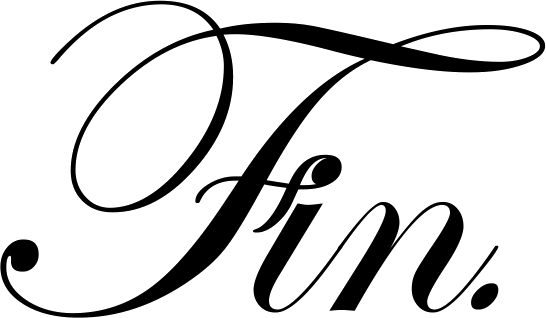